In [1]:
%config InlineBackend.figure_formats = ['svg']
import sys
import time

import numpy as np

# Performance row-order versus major order

## Which order is the data in?

In [2]:
x = np.array(np.arange(15, dtype=np.int8).reshape(3, 5))   # extra `np.array` to not get views from reshape

In [3]:
x

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]], dtype=int8)

In [4]:
x.__array_interface__['data']

(105553169487616, False)

In [5]:
x.data.hex()

'000102030405060708090a0b0c0d0e'

So we have *row-major-order*: the elements are linearly stored in memory by taking one row after the other.

## What does `axis=1` mean for `np.sum()`

In [6]:
x = np.arange(6).reshape(2, 3)  # 2 rows, 3 columns
x

array([[0, 1, 2],
       [3, 4, 5]])

In [7]:
np.sum(x, axis=0)  # sum along columns

array([3, 5, 7])

In [8]:
np.sum(x, axis=1)  # sum along rows

array([ 3, 12])

## Performance

In [9]:
N = 40000

## Experiment with large matrix of 16-bit ints

In [10]:
x = np.random.randint(-100, 100, size=(N, N), dtype=np.int16)
print(f"{x.nbytes/1e6} MB")

3200.0 MB


In [11]:
x.shape

(40000, 40000)

In [12]:
tcol = %timeit -o x.sum(axis=0)  # sum along columns

934 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
trow = %timeit -o x.min(axis=1)  # sum along rows

63 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
print(f"Performance difference is factor {tcol.average/trow.average:.1f}")

Performance difference is factor 14.8


## Experiment with large matrix of 64-bit floats

In [15]:
x = np.random.rand(N//2, N//2)  # try with floats
print(f"{x.nbytes/1e6} MB")

3200.0 MB


In [16]:
tcol = %timeit -o x.sum(axis=0)  # sum along columns

97.5 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
trow = %timeit -o x.min(axis=1)  # sum along rows

113 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
print(f"Performance difference is factor {tcol.average/trow.average:.1f}")

Performance difference is factor 0.9


# Study performance as a function of matrix size

In [20]:
# timings results
t_row = []
t_col = []

# metadata about each test
m_nbytes = []  # size of matrix in bytes
m_shape = []
m_size = []

MB = 1024**2

for i in range(1, 50001, 2500):
    nrows = i
    ncols = i
    # x = np.random.rand(nrows, ncols)
    x = np.random.randint(-100, 100, size=(nrows, ncols), dtype=np.int16)
    m_nbytes.append(x.nbytes)
    m_shape.append(x.shape)
    m_size.append(x.size)
    
    size = x.nbytes/MB
    print(f"{i=:6} -> {size:.1} MB")
    if size > 12*1e3:  # stop at at 12 GB
        print("Matrix becomes too large, stopping")
        break
    
    t = %timeit -o x.sum(axis=0)
    t_col.append(t.average)
    
     # sum along rows first (axis=1)
    t = %timeit -o x.sum(axis=1)
    t_row.append(t.average)


i=     1 -> 2e-06 MB
1.28 µs ± 2.86 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.29 µs ± 10.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
i=  2501 -> 1e+01 MB
3.38 ms ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.21 ms ± 6.32 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
i=  5001 -> 5e+01 MB
13.6 ms ± 61.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.79 ms ± 4.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
i=  7501 -> 1e+02 MB
32.2 ms ± 98.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
19.7 ms ± 25.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
i= 10001 -> 2e+02 MB
59.6 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
35.6 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
i= 12501 -> 3e+02 MB
95.4 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
54.9 ms ± 62.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
i= 1500

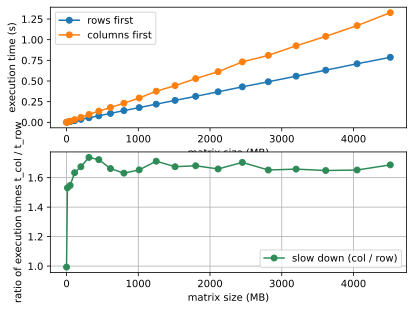

In [21]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1)
ax = axes[0]

sizes = [nbytes/1e6 for nbytes in m_nbytes]

ax.plot(sizes, t_row, 'o-', label='rows first')
ax.plot(sizes, t_col, 'o-', label='columns first')
ax.set_xlabel('matrix size (MB)')
ax.set_ylabel('execution time (s)')
ax.legend()

ax = axes[1]
ratio = np.array(t_col) / np.array(t_row)
ax.plot(sizes, ratio, 'o-', label='slow down (col / row)', color='seagreen')
ax.set_xlabel('matrix size (MB)')
ax.set_ylabel('ratio of execution times t_col / t_row')
ax.legend()
ax.grid()


In [22]:
# save data
import pandas as pd

In [23]:
rows = [r for r,c in m_shape]
df = pd.DataFrame({'rows':rows, 'size':sizes, 't_row':t_row, 't_col':t_col})
df['ratio'] = df['t_col'] / df['t_row']
df.to_csv("performance-data.csv")

In [24]:
df

,rows,size,t_row,t_col,ratio
0,1,0.000002,0.000001,0.000001,0.993316
1,2501,12.510002,0.002207,0.003379,1.530797
2,5001,50.020002,0.008792,0.013602,1.547099
3,7501,112.530002,0.019723,0.032216,1.633445
4,10001,200.040002,0.035581,0.059570,1.674196
5,12501,312.550002,0.054907,0.095391,1.737312
6,15001,450.060002,0.078574,0.135319,1.722180
7,17501,612.570002,0.108139,0.179675,1.661513
8,20001,800.080002,0.141856,0.231297,1.630508
9,22501,1012.590002,0.178185,0.294492,1.652736



Might be worth investigating for smaller matrix sizes.

In [25]:
# data above is gathered on MacBook Air with M2 CPU: 
!sysctl -a | grep brand

machdep.cpu.brand_string: Apple M2
